# Prepare dataset
The purpose of this file is to normalize dataset to have same size along the whole dataset in one run. 
This code finds all audio files from the directory and cuts each of them into smaller pieces of same *length*, optionally with a *stride*. If the  piece of a file is shorter than a *length* but still longer than a *minimum length treshold* zeroes at the end of a file are padded (to make the size equal to *length*).

## Create list of all audio files

In [1]:
import os
import re
from tabulate import tabulate

audioPath = "./data/audio/"
audioFiles = os.listdir(audioPath) # list of all audio files
audioDict = {} # mappings of birds with their audio files

for file in audioFiles:
    bird = re.sub(r'-\d+\..+$', '', file) # Remove "-[id].[format]"
    bird = ''.join([' ' + c if c.isupper() else c for c in bird]).strip() # Convert CamelCase to 'space' case ('BlackBird' to 'Black Bird')
    if bird not in audioDict:
        audioDict[bird] = []
    audioDict[bird].append(file)
    
print("Total number of birds:", len(audioDict))
print("Total number of audio files:", len(audioFiles))
print()
print(tabulate([[bird, len(audioDict[bird])] for bird in audioDict], headers=['Bird', 'Audio Count']))

Total number of birds: 988
Total number of audio files: 14900

Bird                                Audio Count
--------------------------------  -------------
Abbott's Babbler                              9
Aberrant Bush Warbler                        25
Alexandrine Parakeet                         35
Alpine Accentor                               2
Alpine Chough                                 1
Alpine Swift                                  2
Alpine Thrush                                 5
Altai Accentor                                8
Amur Falcon                                   6
Andaman Bulbul                               17
Andaman Coucal                               17
Andaman Crake                                17
Andaman Cuckoo- Dove                          2
Andaman Cuckooshrike                          4
Andaman Drongo                               22
Andaman Flowerpecker                         11
Andaman Green Pigeon                          5
Andaman Hawk- Owl        

## Filter audio files

In [2]:
# We will cut the files of only those birds that have at least MIN_AUDIOS recordings.
# Deleting those birds that have less than MIN_AUDIOS recordings...

MIN_AUDIOS = 50
audioCount = 0

for bird, audios in list(audioDict.items()):
    nAudios = len(audios)
    if nAudios < MIN_AUDIOS:
        del audioDict[bird]
    else:
        audioCount += nAudios

print("Number of birds now:", len(audioDict))
print("Number of audio files now:", audioCount)
print()
print(tabulate([[bird, len(audioDict[bird])] for bird in audioDict], headers=['Bird', 'Audio Count']))

Number of birds now: 51
Number of audio files now: 3744

Bird                               Audio Count
-------------------------------  -------------
Ashy Prinia                                109
Asian Koel                                 128
Black-hooded Oriole                        110
Black Drongo                                71
Blyth's Reed Warbler                        77
Bronzed Drongo                              53
Brown-cheeked Fulvetta                      50
Brown-headed Barbet                         50
Brown Hawk- Owl                             71
Chestnut-crowned Laughingthrush             63
Cinereous Tit                               61
Clamorous Reed Warbler                      56
Common Hawk- Cuckoo                         87
Common Iora                                 83
Common Myna                                 65
Common Tailorbird                          133
Coppersmith Barbet                          66
Great Barbet                                54
Gre

## Find strategy to cut the audio file and create melspectograms
We want to cut files to smaller pieces of the desired size (5 seconds in example), and stride of 1 second. Stride tells us how different pieces of files will overlap at each other.
For each cut, we will generate a melspectogram. The melspectograms of each bird are stored in separate folders.

In [3]:
import gc
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def saveMel(signal, directory):
    gc.enable()
    # MK_spectrogram modified
    N_FFT = 1024          
    HOP_SIZE = 1024        
    N_MELS = 128    
    FMIN = 1400

    fig = plt.figure(1, frameon=False)
    fig.set_size_inches(6,6)

    ax = plt.Axes(fig, [0, 0, 1, 1])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    S = librosa.feature.melspectrogram(y=signal, n_fft=N_FFT, hop_length=HOP_SIZE, n_mels=N_MELS, htk=True, fmin=FMIN)
    librosa.display.specshow(librosa.power_to_db(S**2,ref=np.max), fmin=FMIN) #power = S**2

    fig.savefig(directory)
    plt.ioff()
    fig.clf()
    ax.cla()
    plt.clf()
    plt.close('all')

In [4]:
import warnings
warnings.filterwarnings('ignore')

size = {
    'desired': 5, # [seconds]
    'minimum': 4, # [seconds]
    'stride' : 0, # [seconds]
    'name': 5 # [number of letters]
} # stride should not be bigger than desired length

melsPath = "./data/melspectrogram/"
melDict = {} # mappings of birds with their melspectogram files

for bird, audioFiles in audioDict.items():
    birdDir = melsPath + bird + '/'
    if not os.path.exists(birdDir):
        os.makedirs(birdDir)

    melDict[bird] = []
    for file in audioFiles:
        print('Creating melspectrograms for:', file)
        try:
            signal, sr = librosa.load(audioPath + file) # sr = sampling rate
            step = (size['desired'] - size['stride']) * sr # length of step between two cuts in seconds
            nr = 0
            for start, end in zip(range(0, len(signal), step), range(size['desired'] * sr, len(signal), step)):
                # cut file and save each piece
                nr = nr + 1
                # save the file if its length is higher than minimum
                if end - start > size['minimum'] * sr:
                    melPath = birdDir + file[:-4] + '-' + str(nr) + ".png"
                    saveMel(signal[start : end], melPath)
                    melDict[bird].append(melPath)
                    print('File saved:', melPath)
        except Exception as e:
            print('Error:', e)
        print()

Creating melspectrograms for: AshyPrinia-116338.mp3
Error: Input signal length=0 is too small to resample from 44100->22050

Creating melspectrograms for: AshyPrinia-116339.mp3
Error: Input signal length=0 is too small to resample from 44100->22050

Creating melspectrograms for: AshyPrinia-116340.mp3
Error: Input signal length=0 is too small to resample from 44100->22050

Creating melspectrograms for: AshyPrinia-116341.mp3
Error: Input signal length=0 is too small to resample from 44100->22050

Creating melspectrograms for: AshyPrinia-149798.mp3
Error: Input signal length=0 is too small to resample from 44100->22050

Creating melspectrograms for: AshyPrinia-182174.mp3
Error: Input signal length=0 is too small to resample from 48000->22050

Creating melspectrograms for: AshyPrinia-183296.mp3
Error: Input signal length=0 is too small to resample from 44100->22050

Creating melspectrograms for: AshyPrinia-185369.mp3
Error: Input signal length=0 is too small to resample from 44100->22050



## Show melspectograms

In [5]:
noOfMels = sum([len(melDict[bird]) for bird in melDict])
print("Number of birds:", len(melDict))
print("Number of melspectorgrams:", noOfMels)
print()
print(tabulate([[bird, len(melDict[bird])] for bird in melDict], headers=['Bird', 'Melspectogram Count']))

Number of birds: 51
Number of melspectorgrams: 11553

Bird                               Melspectogram Count
-------------------------------  ---------------------
Ashy Prinia                                        392
Asian Koel                                         459
Black-hooded Oriole                                410
Black Drongo                                       516
Blyth's Reed Warbler                               195
Bronzed Drongo                                     143
Brown-cheeked Fulvetta                             101
Brown-headed Barbet                                148
Brown Hawk- Owl                                    289
Chestnut-crowned Laughingthrush                    100
Cinereous Tit                                      208
Clamorous Reed Warbler                             349
Common Hawk- Cuckoo                                493
Common Iora                                        220
Common Myna                                        263
Common Tail


Displaying 5 melspectograms at random:...


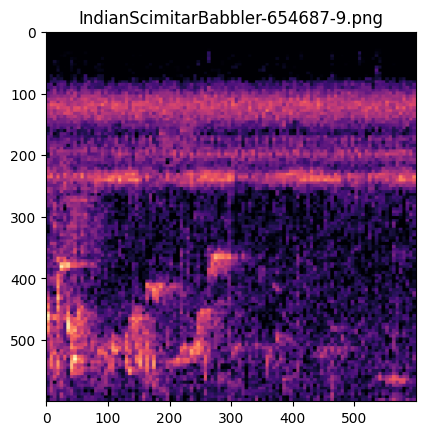

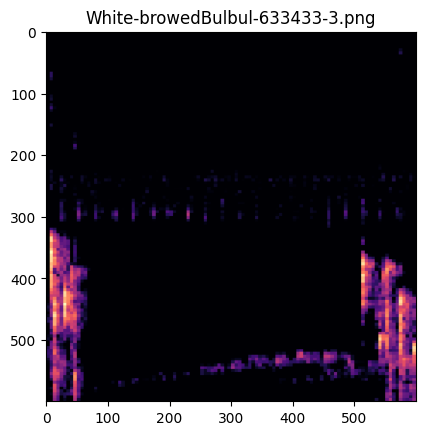

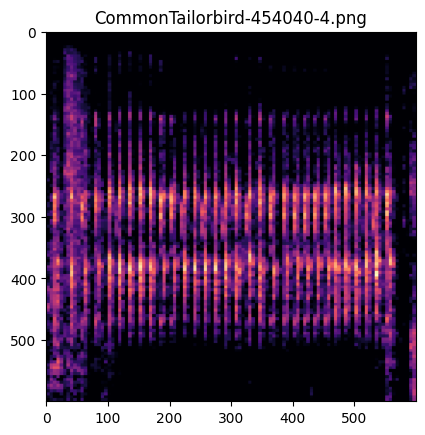

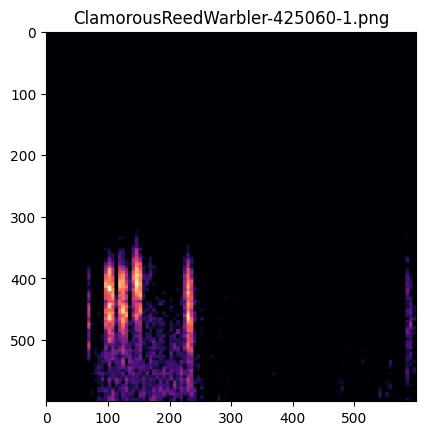

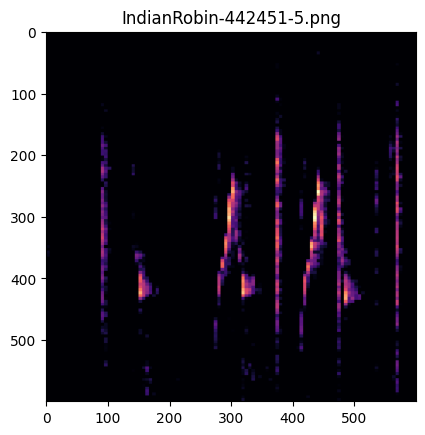

In [12]:
# Display random melspectograms
import matplotlib.image as mpimg
import random

displayCount = 5
print(f'\nDisplaying {displayCount} melspectograms at random:...')

for bird in np.random.choice(list(melDict.keys()), displayCount):
    dir = melsPath + bird + '/'
    mels = os.listdir(dir)
    file = dir + random.choice(mels)
    image = mpimg.imread(file)
    plt.imshow(image)

    melName = re.sub(r'^.*[\\\/]', '', file)
    plt.title(melName)
    plt.show()

# Dataset split

This file divides our dataset into train, validation and test set. We can't use preprogrammed functions to do that, because we divided each of our files into other smallers (i.e. one sound to six images). Putting images made out of same mp3 file might lead to the *data leakage* and make our results *not trustworthy* and *biased*.

In [13]:
# define number of files for all sets
train = 0.8 # 80% of all sound should be in the train set
val = 0.1 # 10% validation set
test = 0.1 # 10% test set
kfolds = 1

trainDict, valDict, testDict = {}, {}, {} # each stores the number of files 

# shuffle the files before splitting them
for bird, mels in melDict.items():
    nMels = len(mels)
    nTrain = int(train * nMels)
    nVal = int(val * nMels)
    nTest = nMels - nTrain - nVal
    random.shuffle(mels)
    trainDict[bird] = mels[ : nTrain]
    valDict[bird] = mels[nTrain : nTrain + nVal]
    testDict[bird] = mels[nTrain + nVal : ]

print(tabulate([(bird, len(trainDict[bird]), len(valDict[bird]), len(testDict[bird])) for bird in audioDict], headers=['Bird', 'Train', 'Validation', 'Test']))

Bird                               Train    Validation    Test
-------------------------------  -------  ------------  ------
Ashy Prinia                          313            39      40
Asian Koel                           367            45      47
Black-hooded Oriole                  328            41      41
Black Drongo                         412            51      53
Blyth's Reed Warbler                 156            19      20
Bronzed Drongo                       114            14      15
Brown-cheeked Fulvetta                80            10      11
Brown-headed Barbet                  118            14      16
Brown Hawk- Owl                      231            28      30
Chestnut-crowned Laughingthrush       80            10      10
Cinereous Tit                        166            20      22
Clamorous Reed Warbler               279            34      36
Common Hawk- Cuckoo                  394            49      50
Common Iora                          176            22 

In [14]:
# Save this split as json
import json

trainJson, valJson, testJson = './data/train.json', './data/val.json', './data/test.json'
with open(trainJson, 'w') as fTrain, open(valJson, 'w') as fVal, open(testJson, 'w') as fTest:
    json.dump(trainDict, fTrain)
    json.dump(valDict, fVal)
    json.dump(testDict, fTest)

print('Saved json files:')
print(trainJson)
print(valJson)
print(testJson)

Saved json files:
./data/train.json
./data/val.json
./data/test.json
